In [1]:
import pynumdiff
import numpy as np
import cvxpy
import matplotlib.pyplot as plt

In [2]:
dt = 0.01
noise_parameters = [0, 0.0001]

In [3]:
noisy_measurements, actual_vals, extras = pynumdiff.utils.simulate.lorenz_xyz(dt=dt, 
                                                                              noise_parameters=noise_parameters)
x = noisy_measurements[0,:]
y = noisy_measurements[1,:]
z = noisy_measurements[2,:]
noisy_measurements = [x, y, z]

In [4]:
def get_library(noisy_measurements):
    x, y, z = noisy_measurements
    library = [x, y, z, x**2, y**2, z**2, x*y, x*z, y*z, 
                         np.sin(x), np.sin(y), np.sin(z), np.ones_like(x)]
    return library

In [51]:
def whiten_library(library):
    white_library = []
    for m in library:
        if np.std(m) < 1e-6:
            white_library.append(m - np.mean(m) + 1)
        else:
            mean_shifted_m = m - np.mean(m)
            white_m = mean_shifted_m / np.std(mean_shifted_m)
            white_library.append(white_m)
    return white_library

In [52]:
def take_derivative(measurements, dt, smoothing_factor=100):
    diff_measurements = []
    for measurement in measurements:
        smooth_measurement, diff_measurement = pynumdiff.total_variation_regularization.jerk(measurement, dt, smoothing_factor)
        diff_measurements.append(diff_measurement)
    return diff_measurements

In [53]:
def sindy(outputs, inputs, gamma, solver='MOSEK'):
    '''
    Run SINDy algorithm. You may wish to whiten the outputs and inputs first. 
    
    Parameters
    ----------
    outputs:  (list of 1D arrays)  - Outputs, traditionally these will be derivatives, e.g. [xdot, ydot, zdot]
    inputs:   (list of 1D arrays)  - Library of inputs, which will be linearly combined with a sparsity
                                     constraint.
    gamma:    (float,              - Weighting of L1 penalty
               or list of floats)    If list, different L1 penalty applied to each output, list should have
                                     same length as inputs list. 
    
    Returns
    -------
    coefficients: (list of 1D arrays)  - list of the coefficients for each input, for each output
    '''
    
    # define coefficients
    coefficients = [cvxpy.Variable( len(inputs) ) for output in outputs]

    # calculate errors
    errors = []
    for o, output in enumerate(outputs):
        e = cvxpy.sum_squares( output - np.vstack(inputs).T*coefficients[o] )
        errors.append(e)
    sum_squared_error = cvxpy.sum(errors)

    # L1 norm penalty
    r = [cvxpy.norm( coeff, 1) for coeff in coefficients]
    
    # Weighted L1 norm penalty
    if type(gamma) is not list:
        gamma = [gamma]*len(r)
    assert len(gamma) == len(r)
    r_weighted = cvxpy.sum([r[i]*gamma[i] for i in range(len(gamma))])

    # Set up and solve the optimization problem
    obj = cvxpy.Minimize(sum_squared_error + r_weighted)
    prob = cvxpy.Problem(obj)
    prob.solve(solver='MOSEK')
    
    return [coeff.value for coeff in coefficients]

In [46]:
outputs = take_derivative(noisy_measurements, dt, smoothing_factor=10)
inputs = get_library(noisy_measurements)
gamma = 10

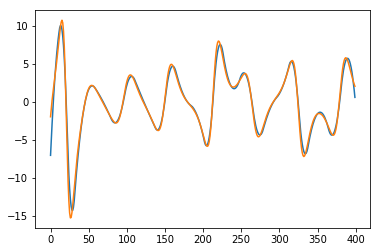

In [58]:
plt.plot(outputs[0].T)
plt.plot(actual_vals[3].T)

In [47]:
coeffs = sindy(outputs, inputs, gamma)
for coeff in coeffs:
    print(coeff)

[-5.17512248e+00  8.13655468e+00  1.36961615e-07  8.18455902e-08
 -1.34034823e-02  1.66673875e-02 -3.95285389e-07  5.14027677e-08
 -3.70798812e-02 -4.58126548e+00  1.89858297e+00  5.93123561e-07
 -5.90816629e-02]
[ 3.01057513e+01  4.74759510e-07 -6.50275308e-08 -1.98202873e+00
 -1.19010032e-07  6.76930465e-02  1.76313366e+00 -1.52666132e+01
 -5.00046218e-01  6.53207085e-07  4.35869766e+00 -3.86893067e-01
 -1.70448052e-07]
[-4.99201755e-08  2.57627042e-01 -1.62246965e+00  9.71289748e+00
  1.11856131e-07 -6.78486445e-01  1.37649153e+01 -1.58003685e-02
 -1.09091694e-01 -9.06672898e-08  1.07455058e-08  5.36341917e-08
  2.66313857e-10]


In [55]:
coeffs = sindy(whiten_library(outputs), whiten_library(inputs), 100)
for coeff in coeffs:
    print(coeff)

[-1.16152491e-07  8.47086469e-01  3.78444191e-09  8.79731767e-09
 -5.34118829e-09 -1.72784870e-10  1.31665470e-08 -5.90166975e-01
  4.58729126e-02 -3.24946279e-07  5.60670922e-07  1.07241472e-08
  1.03214691e-21]
[ 1.25715601e-09  1.74626453e-01 -2.35540250e-02 -3.42425614e-08
  2.83390594e-08 -2.94026994e-07  7.11207109e-09 -8.14190791e-01
 -2.92563189e-09  7.97637136e-09  2.96659436e-01  5.64961396e-09
  2.15404761e-21]
[ 9.89920936e-09  1.66903222e-08 -6.07919587e-03  2.24424318e-08
  1.29260076e-07 -6.60650490e-08  8.51644159e-01  7.06228564e-09
  1.25926386e-08  9.65439342e-09  1.24992786e-08  5.99783180e-09
  3.93037618e-23]


In [ ]:
# iterate sindy to progressively eliminate terms